(greenhouse:solution)=
# Greenhouse model

**Task 1**: Plug Eq. (7) into Eq. (6) and solve for the radiative equilibrium suface temperature $T_e$ 

In [11]:
# Solve for the radiative equilibrium temperature

sigma = 5.67e-8 # W m^-2 K^-4 
Q = 342         # Incoming shortwave radiation W m^-2
albedo = 0.3    # Albedo

Te = (((1-0.3)*342)/5.67e-8)**(1/4)

print('Radiative equilibrium temperature: {:.2f}'.format(Te))

Radiative equilibrium temperature: 254.91


**Task 2**: Where in the atmosphere do we find $T_e$?

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [12]:
## The NOAA ESRL server is shutdown! January 2019
ncep_air = xr.open_dataset('./files/air.mon.ltm.1981-2010.nc',use_cftime=True)

ncep_air

<xarray.Dataset>
Dimensions:             (level: 17, lat: 73, lon: 144, time: 12, nbnds: 2)
Coordinates:
  * level               (level) float32 1e+03 925.0 850.0 ... 30.0 20.0 10.0
  * lat                 (lat) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * lon                 (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * time                (time) object 0001-01-01 00:00:00 ... 0001-12-01 00:0...
Dimensions without coordinates: nbnds
Data variables:
    climatology_bounds  (time, nbnds) object ...
    air                 (time, level, lat, lon) float32 ...
    valid_yr_count      (time, level, lat, lon) float32 ...
Attributes:
    description:                     Data from NCEP initialized reanalysis (4...
    platform:                       Model
    Conventions:                    COARDS
    not_missing_threshold_percent:  minimum 3% values input to have non-missi...
    history:                        Created 2011/07/12 by doMonthLTM\nConvert...
    title:                          monthly ltm air from the NCEP Reanalysis
    dataset_title:                  NCEP-NCAR Reanalysis 1
    References:                     http://www.psl.noaa.gov/data/gridded/data...

In [14]:
#  Take global, annual average and convert to Kelvin
coslat = np.cos(np.deg2rad(ncep_air.lat))   # Take the cosinus of the latitude
weight = coslat / coslat.mean(dim='lat')    # Weigth the latitude (convergence)
Tglobal = (ncep_air.air * weight).mean(dim=('lat','lon','time')) # Take the weighted meadn

# Show the result
Tglobal

<xarray.DataArray (level: 17)>
array([ 15.179084  ,  11.207003  ,   7.8383274 ,   0.21994135,
        -6.4483433 , -14.888848  , -25.570469  , -39.36969   ,
       -46.797905  , -53.652245  , -60.56356   , -67.006065  ,
       -65.53293   , -61.48664   , -55.853584  , -51.593952  ,
       -43.21999   ], dtype=float32)
Coordinates:
  * level    (level) float32 1e+03 925.0 850.0 700.0 ... 50.0 30.0 20.0 10.0

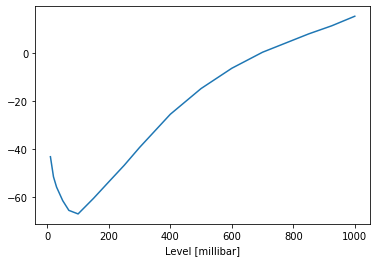

In [15]:
#  a "quick and dirty" visualization of the data
Tglobal.plot()

In [16]:
from metpy.plots import SkewT

Text(0.5, 1.0, 'Global, annual mean sounding from NCEP Reanalysis')

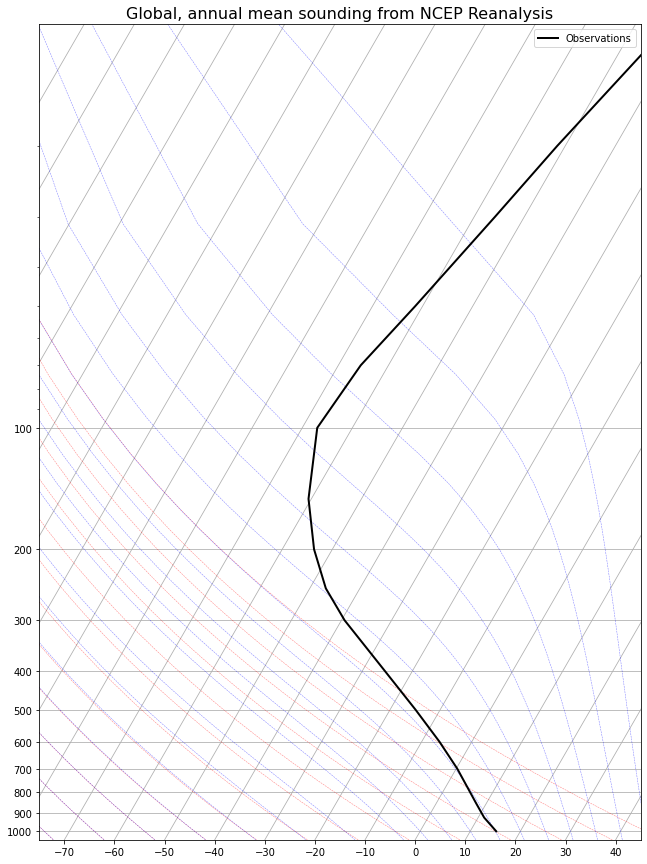

In [22]:
fig = plt.figure(figsize=(15, 15))

# Create the skew-plot with the metpy module
skew = SkewT(fig, rotation=30)
skew.plot(Tglobal.level, Tglobal, color='black', linestyle='-', linewidth=2, label='Observations')
skew.ax.set_ylim(1050, 10)
skew.ax.set_xlim(-75, 45)

# Add the relevant special lines
skew.plot_dry_adiabats(linewidth=0.5)
skew.plot_moist_adiabats(linewidth=0.5)

# Adde axis labels and legend
skew.ax.legend()
skew.ax.set_title('Global, annual mean sounding from NCEP Reanalysis', 
             fontsize = 16)

**Task 3**: What is the surface temperature with the single layer model? 

In [12]:
# Solve for the atmospheric surface temperature

# Calc surface temperature
Ts = 2**(1/4) * Te
print('Surface temperature: {:.2f}'.format(Ts))

Surface temperature: 303.14


Why does the model overestimate the surface temperature?

**Task 5**: Write a Python function for $OLR = U_2 = (1-\epsilon)^2 \sigma T_s^4 + \epsilon(1-\epsilon)\sigma T_0^4 + \epsilon \sigma T_1^4$

In [13]:
def two_layer_model(Ts, T0, T1, epsilon):
    return ((1-epsilon)**2)*sigma*Ts**4 + epsilon*(1-epsilon)*sigma*T0**4 + epsilon*sigma*T1**4

**Task 6**: We will tune our model so that it reproduces the observed global mean OLR given observed global mean temperatures. Determine the temperatures for the two-layer model from the following sounding

![alt text](pics/vertical_profile.png "Sounding")

**Task 8**: Find graphically the best fit value of $\epsilon$


The optimized transmissivity is: 0.59


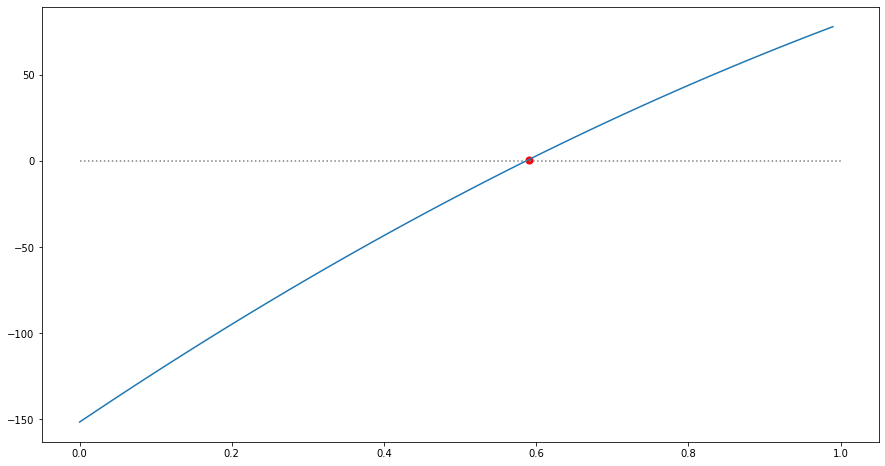

In [60]:
import numpy as np
import matplotlib.pyplot as plt

OLR = []        # initialize array
epsilons = []   # initialize array
OLR_obs = 238.5 # observed outgoing long-wave radiation

# Auxiliary function to find index of closest value 
def find_nearest(array, value):
    idx,val = min(enumerate(array), key=lambda x: abs(x[1]-value))
    return idx

# Optimize epsilon
for eps in np.arange(0, 1, 0.01):
    OLR.append(OLR_obs - two_layer_model(288, 275, 230, eps))
    epsilons.append(eps)

# Find the closest value to the observed OLR
idx = find_nearest(OLR, 0)

# Save the optimized epsilon
epsilon = epsilons[idx]

# Plot the results
print('The optimized transmissivity is: {:.2f}'.format(epsilons[idx]))
plt.figure(figsize=(15,8))
plt.plot(epsilons,OLR);
plt.scatter(epsilons[idx], OLR[idx], s=50,  color='r')
plt.hlines(0,0,1,linestyles='dotted',color='gray');
    

In [117]:
# Validate the result
print('The modelled OLR is {:.2f}, while the observed value is 238.5'.format(two_layer_model(288, 275, 230, epsilon)))

The modelled OLR is 237.63, while the observed value is 238.5


**Task 9**: Write a Python function to calculate each term in the OLR. Plug-in the observed temperatures and the tuned value for epsilon.

In [118]:
def two_layer_terms(Ts, T0, T1, epsilon):
    return ( ((1-epsilon)**2)*sigma*Ts**4, epsilon*(1-epsilon)*sigma*T0**4, epsilon*sigma*T1**4)

In [119]:
term1, term2, term3 = two_layer_terms(288, 275, 230, epsilon)
print('Term 1: {:.2f} \nTerm 2: {:.2f} \nTerm 3: {:.2f} \nTotal: {:.2f}'.format(term1, term2, term3, term1+term2+term3))

Term 1: 65.57 
Term 2: 78.44 
Term 3: 93.62 
Total: 237.63


**Task 10**: Changing the level of emission by adding absorbers, e.g. by 10 %. 
Suppose further that this increase happens abruptly so that there is no time for the temperatures to respond to this change. We hold the temperatures fixed in the column and ask how the radiative fluxes change.

Which terms in the OLR go up and which go down?

In [71]:
term1, term2, term3 = two_layer_terms(288, 275, 230, epsilon+0.1)
print('Term 1: {:.2f} \nTerm 2: {:.2f} \nTerm 3: {:.2f}\nTotal: {:.2f}'.format(term1, term2, term3, term1+term2+term3))

Term 1: 37.49 
Term 2: 69.36 
Term 3: 109.48
Total: 216.33


**Task 11**: Calculate the radiative forcing for the previous simulation

In [113]:
term1, term2, term3 = two_layer_terms(288, 275, 230, epsilon)
term1p, term2p, term3p = two_layer_terms(288, 275, 230, epsilon+0.1)

print('RS: {:.2f}'.format(-(term1p-term1)))
print('R0: {:.2f}'.format(-(term2p-term2)))
print('R1: {:.2f}'.format(-(term3p-term3)))
print('R: {:.2f}'.format(-(term1p-term1)-(term2p-term2)-(term3p-term3)))

RS: 28.09
R0: 9.08
R1: -15.87
R: 21.30


**Task 12**: What is the greenhouse effect for an isothermal atmosphere?

In [114]:
term1, term2, term3 = two_layer_terms(288, 288, 288, epsilon)
term1p, term2p, term3p = two_layer_terms(288, 288, 288, epsilon+0.1)

print('RS: {:.2f}'.format(-(term1p-term1)))
print('R0: {:.2f}'.format(-(term2p-term2)))
print('R1: {:.2f}'.format(-(term3p-term3)))
print('R: {:.2f}'.format(-(term1p-term1)-(term2p-term2)-(term3p-term3)))

RS: 28.09
R0: 10.92
R1: -39.01
R: -0.00


**Task 13**: For a more realistic example of radiative forcing due to an increase in greenhouse absorbers, we use our observed temperatures and the tuned value for epsilon. Assume an increase of epsilon by 2 %.

In [120]:
depsilon = epsilon * 0.02
print(depsilon)

term1, term2, term3 = two_layer_terms(288, 275, 230, epsilon)
term1p, term2p, term3p = two_layer_terms(288, 275, 230, epsilon+depsilon)

print('RS: {:.2f}'.format(-(term1p-term1)))
print('R0: {:.2f}'.format(-(term2p-term2)))
print('R1: {:.2f}'.format(-(term3p-term3)))
print('R: {:.2f}'.format(-(term1p-term1)-(term2p-term2)-(term3p-term3)))

0.0118
RS: 3.72
R0: 0.73
R1: -1.87
R: 2.58
